In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [36]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [7]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [8]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [38]:
# Find the most recent date in the data set.
most_recent_date_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date_row

('2017-08-23',)

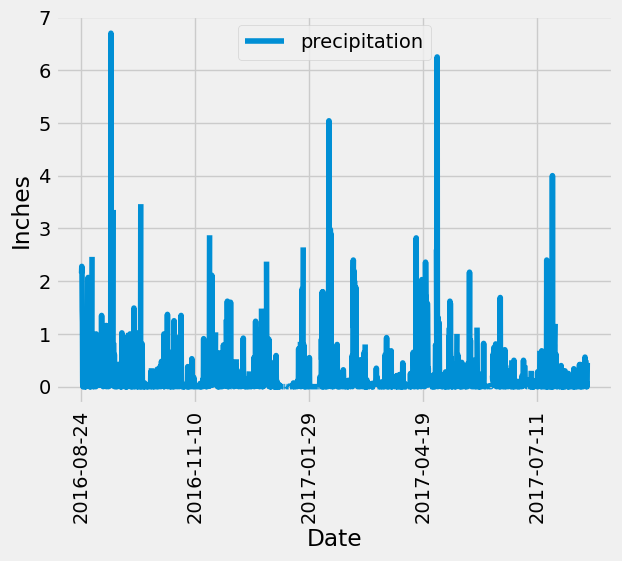

In [82]:
from datetime import datetime, timedelta

# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
most_recent_date = datetime.strptime(most_recent_date_row[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['station', 'date', 'prcp', 'tobs'])

# Sort the dataframe by date
df = df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='date', y='prcp', label='precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation=90, ha='center')
plt.legend(loc='upper center')
plt.show()

In [88]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = pd.DataFrame(df['prcp'].describe())
summary = summary.rename(columns={'prcp': 'precipitation'})
summary

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [92]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [101]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_counts = session.query(Measurement.station, func.count(Measurement.station)).\
group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [108]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_counts[0][0]
most_active_station
most_active_station_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station).all()
most_active_station_stats

[(54.0, 85.0, 71.66378066378067)]

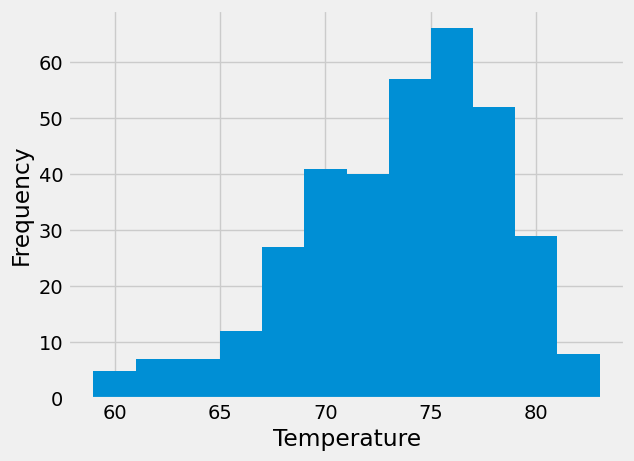

In [122]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_most_active_station = session.query(Measurement.tobs).filter(
    Measurement.station == most_active_station,
    Measurement.date >= one_year_ago
).all()

temperatures = [result[0] for result in last_year_most_active_station]

plt.hist(temperatures, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [123]:
# Close Session
session.close()